# (INFO-F422) Statistical foundations of machine learning: Project 24-25

description: regression task, predict continuous hand proshtesis movement through short time-windows hand pose (angles) from forearm electrode sensors. 

+ author 1
+ author 2
+ author 3

__TODO__: 
+ std dev in addition to avg fro cv scores (may prefere slightly higher cv but with lower var)
+ eval metrics interpretation, ...

___

## Imports

In [ ]:
# models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

# model selection
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

___

## Data loading

In [2]:
data_dir = "data"
pred_dir = "results"

X_g_train = np.load(f"{data_dir}/guided/guided_dataset_X.npy")
y_g_train = np.load(f"{data_dir}/guided/guided_dataset_y.npy")
X_g_test = np.load(f"{data_dir}/guided/guided_testset_X.npy")

X_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_X.npy")
y_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_y.npy")
X_f_test = np.load(f"{data_dir}/freemoves/freemoves_testset_X.npy")


In [3]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


___

## Data preparation

In [4]:
class XWindowAugment(BaseEstimator, TransformerMixin):
    """
    Augment X through overlapping windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        X_windows = np.lib.stride_tricks.sliding_window_view(X,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        X_windows = X_windows[:,:,::step,:]
         
        # (session, electrode, window, time) to (session, window, electrode, time)
        X_windows = X_windows.transpose(0, 2, 1, 3) 
        
        return X_windows   

In [5]:
class yWindowAugment(BaseEstimator, TransformerMixin):
    """
    + Augment y through overlapping windows 
    + Extract target of correspondoing windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, y, X=None):
        return self
    
    def transform(self, y, X=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # ----- window augment -----
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        y_windows = np.lib.stride_tricks.sliding_window_view(y,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        y_windows = y_windows[:,:,::step,:]
         
        # (session, angles, window, time) to (session, window, angles, time)
        y_windows = y_windows.transpose(0, 2, 1, 3)     
        
        # ----- target extract -----
        
        y_windows = y_windows[:, :, :, -1] # keep last hand pose as window target
        
        return y_windows

Prepared data

In [7]:
X_g_train_wdw = XWindowAugment().transform(X_g_train)
y_g_train_wdw = yWindowAugment().transform(y_g_train)

X_f_train_wdw = XWindowAugment().transform(X_f_train)
y_f_train_wdw = yWindowAugment().transform(y_f_train)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_wdw{y_g_train_wdw.shape}\n")

print("Free moves windowed:")
print(f"X_f_train_wdw {X_f_train_wdw.shape} / X_f_test {X_f_test.shape}")
print(f"y_f_train_wdw{y_f_train_wdw.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / X_g_test (5, 332, 8, 500)
y_g_train_wdw(5, 919, 51)

Free moves windowed:
X_f_train_wdw (5, 1079, 8, 500) / X_f_test (5, 308, 8, 500)
y_f_train_wdw(5, 1079, 51)


___

## Evaluation metrics


+ RMSE = $\frac{x}{y}$
    - low
    + high

+ NMSE
    - low
    + high


___

## Cross validation strategy

strategy: session based Leave One Group Out

+ no **window overlap leakage**
+ avoids **session bias**: [sensor drift](https://gebrabit.com/what-does-sensor-drift-mean/), electrode (sensors) placements, experiment conditions, ... 

(knowledge of exact experiments conditions is limitted but session based folds shoudl reduce these assumed biases) 

In [8]:
# Guided session groups
n_sessions_g, n_windows_g, n_electrodes_g, n_times_g = X_g_train_wdw.shape
groups_g = np.repeat(np.arange(1, n_sessions_g+1), n_windows_g) # [1 ... 1], [2 ... 2], ..., [5 ...5] (each group of lenght n_windows)

# Free move session groups
n_sessions_f, n_windows_f, n_electrodes_f, n_times_f = X_f_train_wdw.shape
groups_f = np.repeat(np.arange(1,n_sessions_f+1), n_windows_f)

In [ ]:
# loss functions
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true-y_hat)**2))
def nmse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)/np.std(y_true)**2

# scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
nmse_scorer = make_scorer(nmse, greater_is_better=False)

# cv function 
logo = LeaveOneGroupOut()
def logo_cv(X, y, model, groups, scorer=rmse_scorer):
    cv_scores = cross_val_score(model, X, y, groups=groups, cv=logo, scoring=scorer, n_jobs=-1)
    return np.mean(-cv_scores)

In [18]:
# custom by hand (more specific results)
def _logo_cv(X, y, model, groups):
    nmse_results = []
    rmse_results = []
    for train_index, test_index in logo.split(X, y, groups):
        X_tr, X_ts = X.iloc[train_index], X.iloc[test_index] # df
        y_tr, y_ts = y[train_index], y[test_index]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_ts)
        rmse_results.append(rmse(y_ts, y_hat))
        nmse_results.append(nmse(y_ts, y_hat))
    
    rmse_cv, rmse_std = np.mean(rmse_results), np.std(rmse_results)
    nmse_cv, nmse_std = np.mean(nmse_results), np.std(nmse_results)
    return rmse_cv, nmse_cv, rmse_std, nmse_std

___

## Common time features extraction

+ Mean Absolute Value (MAV)
+ Root Mean Square (RMS)
+ Variance (VAR)
+ Standard Deviation (STD)
+ Zero Crossing (ZC)
+ Myopulse Percentage Rate (MPR)

In [ ]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracts common time-domain features, from numpy arrays into a dataframe (readability)
    """

    def __init__(self, mpr_threshold=0.5):
        self.mpr_threshold = mpr_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        # --- Feature extraction ---
        feature_names = ["MAV", "RMS", "VAR", "STD", "ZC", "MPR"]
        n_features = len(feature_names)
        
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        features = np.zeros((n_sessions * n_windows, n_electrodes * n_features))
        
        for s in range(n_sessions):
            for w in range(n_windows):
                i = s*n_windows + w # index in flattened contiguous windows samples 'form'
                wdw_features = []
                for e in range(n_electrodes):
                    signal = X[s, w, e, :] # window signal
                    
                    mav = np.mean(np.abs(signal))
                    rms = np.sqrt(np.mean(signal**2))
                    var = np.var(signal)
                    std = np.std(signal)
                    zc = np.sum(np.diff(np.signbit(signal)).astype(int))
                    mpr = np.mean(np.abs(signal) > self.mpr_threshold)    
                    wdw_features.extend([mav, rms, var, std, zc, mpr])
                
                features[i, :] = wdw_features
        
        # --- to Dataframe ---            
        column_names = [f"elec{e}_{name}" for e in range(n_electrodes) for name in feature_names]
        df = pd.DataFrame(features, columns=column_names)
        
        return df

In [11]:
class TargetFlattener(BaseEstimator, TransformerMixin):
    """
    Flatten feature set for sklearn usability
    """

    def fit(self, y, X=None):
        return self

    def transform(self, y, X=None):      
        
        # -- Reshape --
        n_sessions, n_windows, n_angles = y.shape
        
        # Reshape to (sessions*windows, angles)
        y_flat = y.reshape(n_sessions * n_windows, n_angles)
        
        return y_flat

Preprocessed data 

In [13]:
X_g_train_preproc = FeatureExtractor().transform(X_g_train_wdw)
y_g_train_preproc = TargetFlattener().transform(y_g_train_wdw)

X_f_train_preproc = FeatureExtractor().transform(X_f_train_wdw)
y_f_train_preproc = TargetFlattener().transform(y_f_train_wdw)

print("Guided preprocessed:")
print(f"X_g_train_preproc {X_g_train_preproc.shape}")
print(f"y_g_train_preproc{y_g_train_preproc.shape}\n")

print("Free move preprocessed:")
print(f"X_f_train_preproc {X_f_train_preproc.shape}")
print(f"y_f_train_preproc{y_f_train_preproc.shape}")

Guided preprocessed:
X_g_train_preproc (4595, 48)
y_g_train_preproc(4595, 51)

Free move preprocessed:
X_f_train_preproc (5395, 48)
y_f_train_preproc(5395, 51)


___

## Baselines

1) Baseline exploration

2) analyse feature importance

3) best feature selection 

4) final baseline selection

#### 1) Baseline 'exploration'

+ try 2 baseline models from different model families (linear, tree based) to get a sense of data/model interaction, early signals of what models (assumptions) seems to work well on data.

+ establishes a cross validation score benchmark that more complex models should beat (to be worth the complexity).

(default parametres - just get a sense of data/model interacton)

__note__: no leakage from feature extraction being outside cross validation loop (work directly with X_g_train_preproc, y_g_train_preproc), since feature extraction operates at window level and logo folds are session based (use of window information only), so no validation set information is leaked (independant sessions).

In [ ]:
cv_results_baselines_g = {}
cv_results_baselines_f = {}

baselines = {
    "dummy_mean": DummyRegressor(strategy='mean'),
    "ols": make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1)), # add standardization for coefs interpretability, ...
    "random_forest": RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=10),
}

# TODO: better visualization (plot?)

# guided
for name, model in baselines.items():
    rmse_cv, nmse_cv, rmse_std, nmse_std = _logo_cv(X_g_train_preproc, y_g_train_preproc, model, groups_g)
    cv_results_baselines_g[name] = {"rmse": rmse_cv, "rmse_std": rmse_std, "nmse": nmse_cv, "nmse_std": nmse_std}

# free move
for name, model in baselines.items():
    rmse_cv, nmse_cv, rmse_std, nmse_std = _logo_cv(X_f_train_preproc, y_f_train_preproc, model, groups_f)
    cv_results_baselines_f[name] = {"rmse": rmse_cv, "rmse_std": rmse_std, "nmse": nmse_cv, "nmse_std": nmse_std}

baselines_cv_df_g = pd.DataFrame(cv_results_baselines_g).T
baselines_cv_df_f = pd.DataFrame(cv_results_baselines_f).T

In [61]:
baselines_cv_df_g

,rmse,rmse_std,nmse,nmse_std
dummy_mean,14.259043,0.260633,0.437812,0.012145
ols,7.248052,0.489468,0.113622,0.015742
random_forest,5.094033,0.706987,0.056900,0.016322


In [62]:
baselines_cv_df_f

,rmse,rmse_std,nmse,nmse_std
dummy_mean,12.892779,1.769289,0.292550,0.024441
ols,11.372697,1.915888,0.226709,0.028622
random_forest,11.144964,1.921988,0.217799,0.029928


__Observations__:

+ both models cut prediction error in half, this indicates that the dataset is relevant, meaning prediction/valuable information can be extracted from the features.

+ evidence of linear structure, linear regression explains ~75% of the dummy mean variance (NMSE reduced by ~75%).

+ additional non linear structure evidence, random forest further reduce prediction error (not as severe as from dummy to linear but still an early signal of 'structure')

(interesting to see jumps from dummy mean to linear to non linear, can help visualize/sense complexity/assumptions impact gradually)


In [63]:
# wont work with dummy mean no more
del baselines['dummy_mean']

#### 2) Feature importance

informative, to be used in feature selection, it must be done correctly avoiding leakage (see step 3 below).

__OLS__

```python
coef_ = [w_1_1, w_1_2, ..., w_1_48],  # weights of model 1
        ...
        [w_51_1, ..., w_51_48]        # weights of model 51
```
For interpretability and to get a general insight we aggregate the feature importances across all outputs by taking the mean (abs to avoid negative weights to cancel out).

(inspired by [external src](https://sourcebae.com/blog/how-to-get-coefficients-and-feature-importances-from-multioutputregressor/) and Tp5)

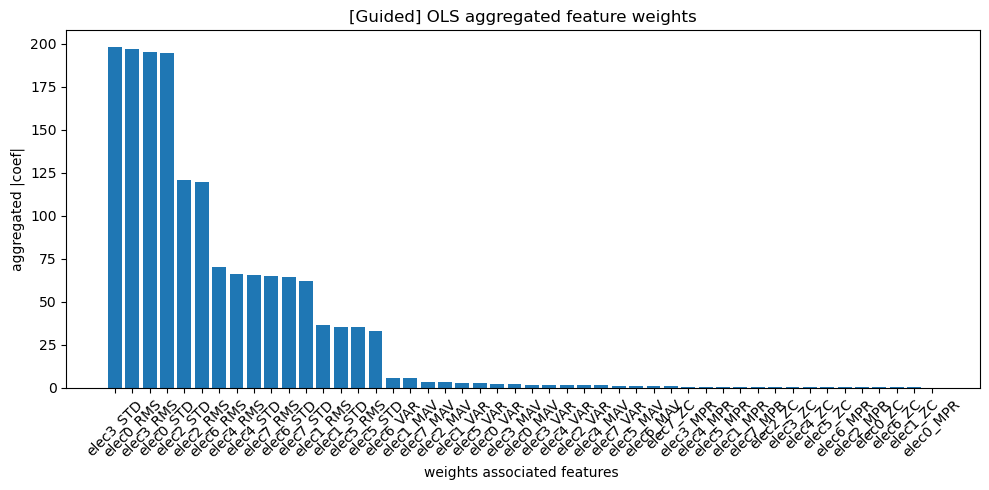

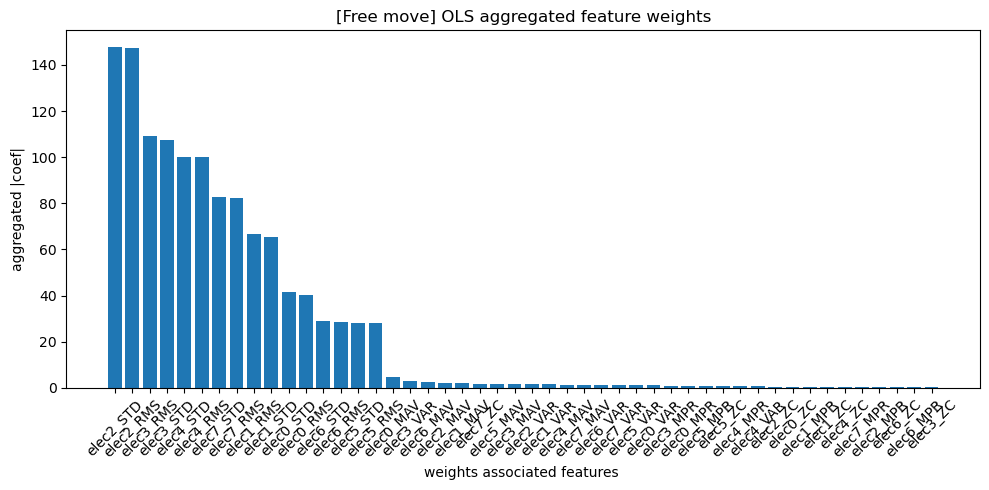

In [72]:
baseline_ols = baselines['ols']
column_names = X_g_train_preproc.columns

def plot_ols_coefs(ols_reg, title:str):
    aggr_coef = np.mean(np.abs(ols_reg.coef_), axis=0) # average on columns
    ols_sorted_idx = np.argsort(aggr_coef)[::-1] # descending order

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(aggr_coef)), aggr_coef[ols_sorted_idx], align='center')
    plt.xticks(range(len(aggr_coef)), column_names[ols_sorted_idx], rotation=45)
    plt.xlabel("weights associated features ")
    plt.ylabel("aggregated |coef|")
    plt.title(f"[{title}] OLS aggregated feature weights")
    plt.tight_layout()
    plt.show()

baseline_ols.fit(X_g_train_preproc, y_g_train_preproc)
plot_ols_coefs(baseline_ols[-1], "Guided")

baseline_ols.fit(X_f_train_preproc, y_f_train_preproc)
plot_ols_coefs(baseline_ols[-1], "Free move")


Observations: 

+ STD and RMS leading weights, other features nearly dropped, not considered. Coherence between guided and free moves
+ electrodes 2 and 3 dominant
+ hald the features are not considered/impactful, feature selection might be relevant

__Random forest__

We use the built in fitted 'features_importances_' attribute, but lets explain what exactly it represents, how is it calculated to interpret these scores at a deeper level than a simple ranking (might give deeper insights for next steps searhc direction).

For a feature j, each tree measures the total (sum) variance reduction (impurity) across all 51 outputs of every node splitting on j, summing the score for every such node in the tree, then, at forest level, this score is averaged over all tress to get the final importance score (then normalized)

Interpretation: how much on average splitting on that feature reduced impurity in the whole forest across all targets

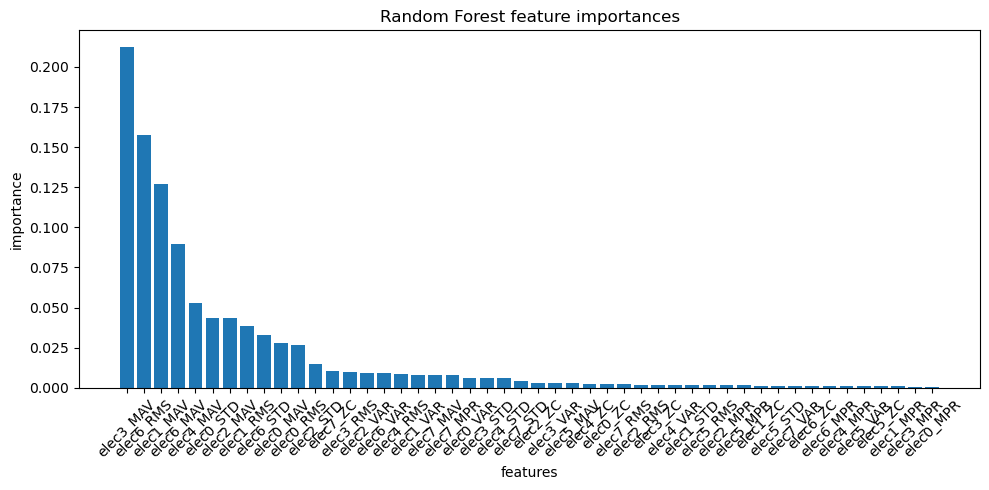

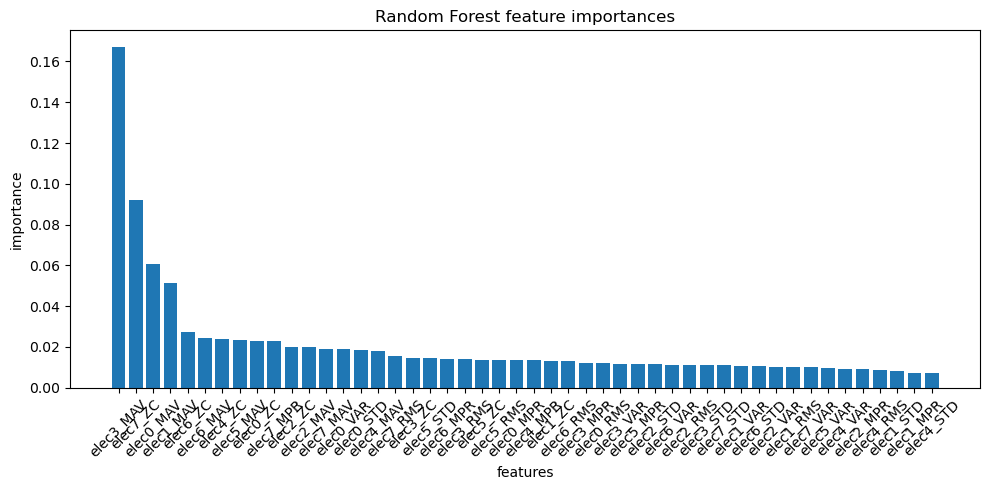

In [67]:
column_names = X_g_train_preproc.columns
baseline_rf = baselines['random_forest']

def plot_rf_feat_imp(rf_reg, title:str):
    feat_imp = rf_reg.feature_importances_
    sorted_idx = np.argsort(feat_imp)[::-1] # descending order

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feat_imp)), feat_imp[sorted_idx], align='center')
    plt.xticks(range(len(feat_imp)), column_names[sorted_idx], rotation=45)
    plt.xlabel("features")
    plt.ylabel("importance")
    plt.title("Random Forest feature importances")
    plt.tight_layout()
    plt.show()

baseline_rf.fit(X_g_train_preproc, y_g_train_preproc)
plot_rf_feat_imp(baseline_rf, "Guided")

baseline_rf.fit(X_f_train_preproc, y_f_train_preproc)
plot_rf_feat_imp(baseline_rf, "Guided")

Observations:
+  Guided and free move nto coherant

#### 3) Feature selection

We experiment feature selection on baseline models with 2 different feature selection strategies (filter and embedded) through a cross validated pipeline to avoid **data leakage**.

- If done separately (rank features before), features scores are computed using validation set information, so selection is done with data leakage.

**note**: We dont do hyper parametre tuning yet, the goal is to find the best (model + feature selection strategy) combination with default models. Even if hyperparametres logically can interact with feature selection, it is a trade off we accept (for the reasons explained above), if we had to handle it, it would be done with [nested cv](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) to avoid leakage (tune and eval on same data).

(inspired from Tp5 and Tp3)

__PCA__

method by hand and pipeline + grid search were implemented, both result in same results, second method less prone to error (leak) and faster (gridsearch api optimized), so first one is here for justification and ensure results coherance both ways.

(We add a standardization step to every pipeline using PCA as it is scale sensitive, to avoid biased components)

In [ ]:
"""
cv_results = 
    [
        [fold1_1c, fold2_1c, ... fold5_1c],
        [fold1_2c, fold2_2c, ... fold5_2c],
        ...
        [fold1_48c, fold2_48c, ... fold5_48c],
    ]
"""

n_features = X_g_train_preproc.shape[1]

def pca_loop_feat_selec(model):
    CV_err = np.zeros((n_features,n_sessions)) # (48, 5)
    for fold, (train_index, test_index) in enumerate(logo.split(X_g_train_preproc, y_g_train_preproc, groups=groups)):
        X_tr, X_ts = X_g_train_preproc.iloc[train_index], X_g_train_preproc.iloc[test_index]
        y_tr, y_ts = y_g_train_preproc[train_index], y_g_train_preproc[test_index]
        
        # fold independant PCA - no leaking
        pca = PCA(random_state=0)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_ts_scaled = scaler.transform(X_ts) # transform with fitted params on X_tr !
        X_ts_pca = pca.transform(X_ts_scaled) # transform with fitted params on X_tr !
        for k in range(n_features):
            model.fit(X_tr_pca[:, :k+1], y_tr) # train on k-best components
            y_hat = model.predict(X_ts_pca[:, :k+1])
            CV_err[k, fold] = rmse(y_hat, y_ts)

    best_n_components = 1
    best_cv_rmse = float('inf')
    for k in range(n_features):
        cv_rmse = np.mean(CV_err[k])
        if cv_rmse < best_cv_rmse:
            best_n_components = k+1 # (we worked with index nto with n_components)
            best_cv_rmse = cv_rmse
    
    return best_n_components, best_cv_rmse

def pca_grid_feat_selec(model, scorer=rmse_scorer):
    pipe = make_pipeline(
        StandardScaler(),
        PCA(),
        model
    )

    param_grid = {'pca__n_components': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

    best_n_components = grid.best_params_['pca__n_components']
    best_cv_rmse = -grid.best_score_
    
    return best_n_components, best_cv_rmse

In [30]:
for name, model in baselines.items():
    best_n_components, best_cv_rmse = pca_grid_feat_selec(model)
    # best_n_components, best_cv_rmse = pca_loop_feat_selec(model)

    print(f"[{name}] Optimal #components = {best_n_components} with cv rmse = {best_cv_rmse}")

[OLS] Optimal #components = 44 with cv rmse = 7.2469824568609225
[random_forest] Optimal #components = 29 with cv rmse = 5.932865285720984


Observations: 

for random forest, this method doesnt outperform raw model as the scaling step might weaken previously clear / obvious splits. We get improvements without the scalign step but still less then next method and not 'guideline' (PCA requires scaling so if it underperforms then PCA shoudlnt be used with tree based models)

__Embedded__

We set threshold=0 to have 'pure' feature selection, otherwise some features get discarded as the default threshold uses a mean strategy.

We use same model for pipeline final estimator and embedded feature importances estimator by convention (could try all 4 combinations) as both models have native feature importances (coefs_, feature_importances_) and thus are supported by SelectFromModel.

In [14]:
def embeded_grid_feat_selec(model, scorer=rmse_scorer):
    pipe = Pipeline([
        ('select', SelectFromModel(model, threshold=0)),
        ('model', model)
    ])

    # param_grid = {'selectfrommodel__max_features': [i for i in range(1, n_features+1)]}
    param_grid = {'select__max_features': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X_g_train_preproc, y_g_train_preproc, groups=groups)

    best_n_features = grid.best_params_['select__max_features']
    best_cv_rmse = -grid.best_score_
    
    return best_n_features, best_cv_rmse

In [66]:
for name, model in baselines.items():
    best_n_features, best_cv_rmse = embeded_grid_feat_selec(model)
    
    print(f"[{name}] Optimal #features = {best_n_features} with cv rmse = {best_cv_rmse}")

[OLS] Optimal #features = 48 with cv rmse = 7.248052301254961
[random_forest] Optimal #features = 34 with cv rmse = 4.960515907891919


#### 4) Final baseline

Select as final baseline, the best performing [feature selection + baseline model] combination explored (infinite possibilities).

In [15]:
base_baseline = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=10)
best_baseline_pipe = make_pipeline(
    FeatureExtractor(),
    SelectFromModel(base_baseline, threshold=0, max_features=34),
    base_baseline
)

In [22]:
# Guided
best_baseline_pipe.fit(X_g_train_wdw, y_g_train_preproc) # train on windowed data since pipeline must contain Feature extractor to predict not preprocessed X_g_test, since X_g_train_preproc already preprocessed 
guided_predictions = best_baseline_pipe.predict(X_g_test)
print(guided_predictions.shape)

# Freemove
X_f_train_wdw = XWindowAugment().transform(X_f_train)
y_f_train_wdw = yWindowAugment().transform(y_f_train)
y_f_train_preproc = TargetFlattener().transform(y_f_train_wdw)

best_baseline_pipe.fit(X_f_train_wdw, y_f_train_preproc)
freemoves_predictions = best_baseline_pipe.predict(X_f_test)
print(freemoves_predictions.shape)

# baseline prediction file
baseline_predictions = np.vstack((guided_predictions, freemoves_predictions))
print(f"final pred array shape {baseline_predictions.shape}")

baseline_predictions_df = pd.DataFrame(baseline_predictions)
baseline_predictions_df.to_csv(f'{pred_dir}/baseline_predictions.csv', index=False)

(1660, 51)
(1540, 51)
final pred array shape (3200, 51)


___

## More complex approaches